This is a POC for the project that involves training a fine-tuned MobileNet model on a custom dataset of sign language digits and predicting the sign language digit that we will turn into a modularized project.


You can acess the data from [Github](https://github.com/ardamavi/Sign-Language-Digits-Dataset).


### The POC.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random

In [2]:
# Organizing the data into train, validation and test sets
os.chdir(r'D:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\data\raw\Dataset')

if not os.path.exists('train') or not os.path.exists('validation') or not os.path.exists('test'):
    os.makedirs('train')
    os.makedirs('validation')
    os.makedirs('test')

# Copying the images into the respective directories    
    for i in range(0, 10):
        os.makedirs(f'train/class_{i}', exist_ok=True)
        os.makedirs(f'validation/class_{i}', exist_ok=True)
        os.makedirs(f'test/class_{i}', exist_ok=True)
        for file in os.listdir(str(i)):
            shutil.move(os.path.join(str(i), file), f'train/class_{i}')

        valid_samples = random.sample(os.listdir(f'train/class_{i}'), 30)
        for sample in valid_samples:
            shutil.move(f'train/class_{i}/{sample}', f'validation/class_{i}/{sample}')

        test_samples = random.sample(os.listdir(f'train/class_{i}'), 5)
        for sample in test_samples:
            shutil.move(f'train/class_{i}/{sample}', f'test/class_{i}/{sample}')
os.chdir(r'D:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\notebooks')

In [3]:
train_data_path = r'D:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\data\raw\Dataset\train'
validation_data_path = r'D:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\data\raw\Dataset\validation'
test_data_path = r'D:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\data\raw\Dataset\test'

# Loading the data
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical')

validation_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    validation_data_path,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical')

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input).flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical',
    shuffle=False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [4]:
processed_data_path = r'D:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\data\processed'
os.makedirs(processed_data_path, exist_ok=True)

# Function to save batches as numpy arrays
def save_batches(batches, filename):
    images, labels = next(batches)
    np.savez(os.path.join(processed_data_path, filename), images=images, labels=labels)

# Function to load batches from numpy arrays
def load_batches(filename):
    data = np.load(os.path.join(processed_data_path, filename))
    return data['images'], data['labels']

# Save a sample batch from each dataset
save_batches(train_batches, 'train_batch_sample.npz')
save_batches(validation_batches, 'validation_batch_sample.npz')
save_batches(test_batches, 'test_batch_sample.npz')

print("Sample batches saved successfully.")

# Retrieve the saved batches
train_images, train_labels = load_batches('train_batch_sample.npz')
validation_images, validation_labels = load_batches('validation_batch_sample.npz')
test_images, test_labels = load_batches('test_batch_sample.npz')

print("Sample batches retrieved successfully.")
print(f"Train batch shape: {train_images.shape}, Labels shape: {train_labels.shape}")
print(f"Validation batch shape: {validation_images.shape}, Labels shape: {validation_labels.shape}")
print(f"Test batch shape: {test_images.shape}, Labels shape: {test_labels.shape}")


Sample batches saved successfully.
Sample batches retrieved successfully.
Train batch shape: (10, 224, 224, 3), Labels shape: (10, 10)
Validation batch shape: (10, 224, 224, 3), Labels shape: (10, 10)
Test batch shape: (10, 224, 224, 3), Labels shape: (10, 10)


In [5]:
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Save the model to the saved folder
model_save_path = os.path.join('..','models','saved_models', 'originalmobilenet_v2_base.keras')
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
mobilenet_model.save(model_save_path)
print(f"MobileNetV2 base model saved to {model_save_path}")

MobileNetV2 base model saved to ..\models\saved_models\originalmobilenet_v2_base.keras


In [6]:
# Unfreeze the last few layers of the MobileNetV2 base
for layer in mobilenet_model.layers[-20:]:
    layer.trainable = True

# Add more layers
x = mobilenet_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.models.Model(mobilenet_model.input, x)

In [7]:
model.compile(
    optimizer= 'adam', #Adam(lr=0.000001)
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


# Create a learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6  # 2.0000e-04
)

# Train the model
history = model.fit(
    train_batches,
    validation_data=validation_batches,
    epochs=20,
    callbacks=[lr_scheduler],
)

Epoch 1/20


d:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\venv\Lib\site-packages\keras-3.5.0-py3.11.egg\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 146s 636ms/step - accuracy: 0.5712 - loss: 1.2710 - val_accuracy: 0.3833 - val_loss: 7.4253 - learning_rate: 0.0010
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 105s 613ms/step - accuracy: 0.8862 - loss: 0.4050 - val_accuracy: 0.3033 - val_loss: 8.2708 - learning_rate: 0.0010
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 105s 610ms/step - accuracy: 0.9519 - loss: 0.1580 - val_accuracy: 0.5700 - val_loss: 3.5691 - learning_rate: 0.0010
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 105s 611ms/step - accuracy: 0.9483 - loss: 0.2137 - val_accuracy: 0.1133 - val_loss: 18.0369 - learning_rate: 0.0010
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 106s 614ms/step - accuracy: 0.9493 - loss: 0.2136 - val_accuracy: 0.1067 - val_loss: 15.7304 - learning_rate: 0.0010
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 106s 613ms/step - accuracy: 0.9435 - loss: 0.2070 - val_accuracy: 0.1000 - val_loss: 33.4413 - learning_rate: 0.0010
Epoch 7/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 106s 615ms/step - accuracy: 0.96

In [8]:
# Save the model to the saved folder
model_save_path = os.path.join('..','models','saved_models', 'finetuned_mobilenetv2_model.keras')
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)
print(f"finetuned_mobilenetv2_model base model saved to {model_save_path}")


finetuned_mobilenetv2_model base model saved to ..\models\saved_models\finetuned_mobilenetv2_model.keras


In [9]:
# Load the fine-tuned model
model_load_path = os.path.join('..', 'models', 'saved_models', 'finetuned_mobilenetv2_model.keras')
loaded_model = tf.keras.models.load_model(model_load_path)
print(f"Fine-tuned MobileNetV2 model loaded from {model_load_path}")

# Verify the model structure (optional)
loaded_model.summary()


Fine-tuned MobileNetV2 model loaded from ..\models\saved_models\finetuned_mobilenetv2_model.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 7,201,504 (27.47 MB)

 Trainable params: 2,389,130 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,778,262 (18.23 MB)

In [10]:
test_labels = test_batches.classes

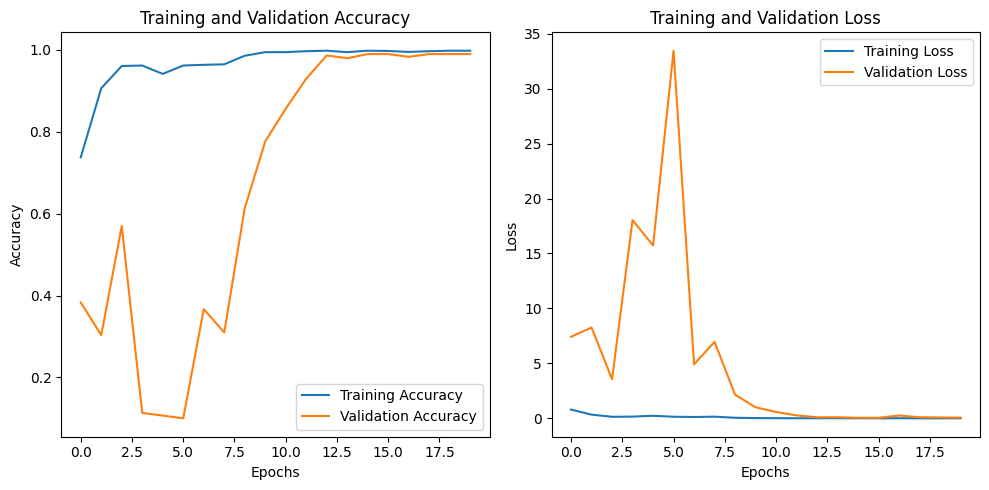

In [13]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(10, 5))

# Plotting the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
predictions = loaded_model.predict(test_batches)

d:\Projects\AI Tutorials\TensorFlow\Fine-Tuned-MobileNet-On-Sign-Language-Digits\venv\Lib\site-packages\keras-3.5.0-py3.11.egg\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 264ms/step


<Figure size 1000x1000 with 0 Axes>

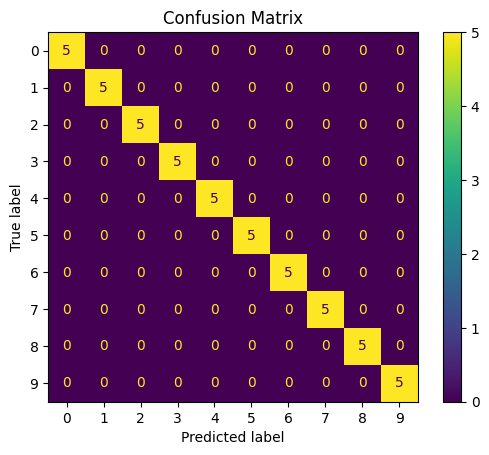

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50



In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()

# Print classification report (optional)
from sklearn.metrics import classification_report
print(classification_report(test_labels, predicted_classes))


----------

###  Testing the Modular code